# Regularized least squared problem with kernels from bottom up

### import libraries

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.preprocessing import StandardScaler
from numpy.random import randn

### General system for damped oscilator

$
\ddot{x}(t) + 2\zeta\omega_0 \dot{x}(t) + \omega_0^2 x(t) = 0
$

#### Description of variables:
- $ x(t) $: position 
- $ \dot{x}(t) $: Velocity 
- $ \ddot{x}(t) $: acceleration
- $ \zeta $: The damping factor, which determines how quickly the oscillations decay (due to friction or resistance).
- $ \omega_0 $: The natural frequency of the system (eigenfrequency)
- $ t $: Time unit.

In [23]:
def damped_oscillator(t, y):  #remember that independent value t comes first
    zeta = 1*0.4/np.sqrt(2)
    omega_0 = 0.1* 2* np.pi
    y_dot = - 2* zeta * omega_0 * y[1] - omega_0**2 * y[0] # x'' = -2*z*w0*x' - w0^2 * x rewritten as a system of first order 
    return [y[1], y_dot]  #y[1] = velocity and y_dot = acceleration. return both since system is rewritten as 2 first order diffs.

### solving the differential equation numerically with scipy

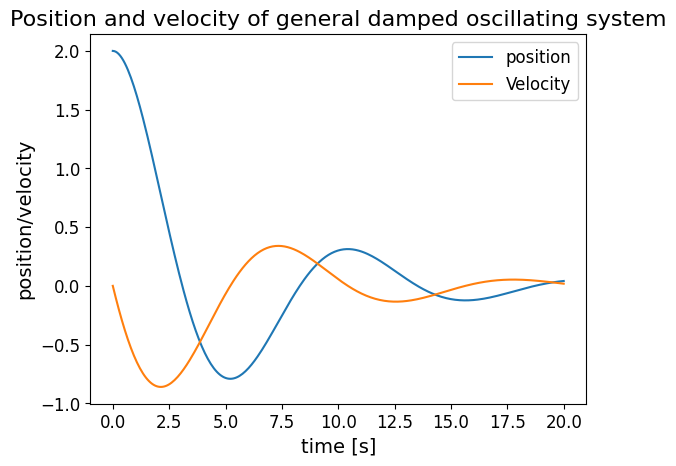

In [24]:
sol = solve_ivp(damped_oscillator, (0, 100), (2, 0), t_eval = np.linspace(0, 20, 300))#time interval first, then initial values for position and velocity
t = sol.t
x,y  = sol.y        #sol.y contains solutions for position and velocity calculated over t_eval as a 2d array


plt.rcParams.update({
    'font.size': 12,           # Base font size
    'axes.titlesize': 16,      # Title font size
    'axes.labelsize': 14,      # Axis label font size
    'xtick.labelsize': 12,     # X-axis tick label size
    'ytick.labelsize': 12,     # Y-axis tick label size
    'legend.fontsize': 12,     # Legend font size
})
plt.plot(t, x, label = "position")
plt.plot(t, y, label = "Velocity")
plt.xlabel("time [s]")
plt.ylabel("position/velocity")
plt.title("Position and velocity of general damped oscillating system")
plt.legend()
plt.show()

### Phase plot of the oscilator

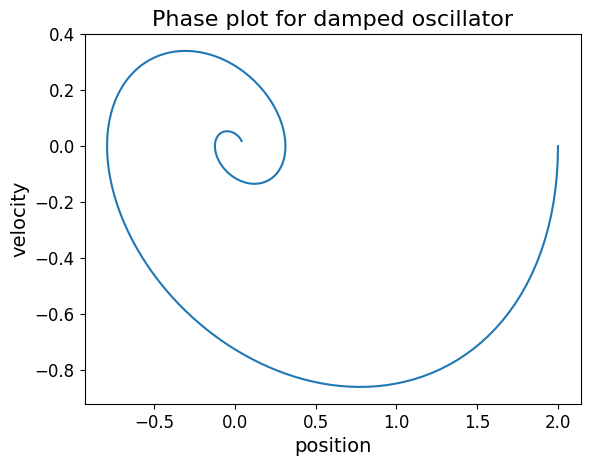

In [25]:
plt.plot(x, y)
plt.xlabel("position")
plt.ylabel("velocity")
plt.title("Phase plot for damped oscillator")
plt.show()

### Discretizing the dataset for with gaussian noise

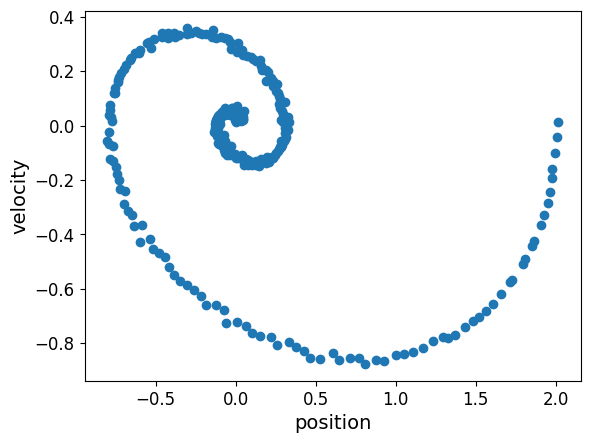

"\nx = np.linspace(0, 2 * np.pi, 50)  # 10 points between 0 and 2π\ny = np.sin(x) + 0.10 * np.random.randn(50)  # Sine values with some noise\n\n# Use x as position data and y as the target for kernel ridge regression\npos_data = x\nvel_data = y\nplt.plot(pos_data, vel_data, 'o')\n"

In [26]:

pos_data = x[::]
vel_data = y[::]
gaussian_noise = np.random.normal(0, 0.01, len(pos_data))
pos_data = pos_data + gaussian_noise
vel_data = vel_data + gaussian_noise
#pos_data = np.column_stack((t, pos_data))
plt.plot(pos_data, vel_data, 'o')
plt.xlabel("position")
plt.ylabel("velocity")
plt.show()

"""
x = np.linspace(0, 2 * np.pi, 50)  # 10 points between 0 and 2π
y = np.sin(x) + 0.10 * np.random.randn(50)  # Sine values with some noise

# Use x as position data and y as the target for kernel ridge regression
pos_data = x
vel_data = y
plt.plot(pos_data, vel_data, 'o')
"""

### Standardize the data

#### Tuning of $𝜆$ and $𝛼$
 - Lambda ($𝜆$): This is the regularization parameter that controls the trade-off between minimizing error on the training data and keeping the model complexity low. Higher $𝜆$ values apply stronger regularization, leading to simpler, smoother solutions that generalize better.

 - Sigma ($𝜎$): In the RBF kernel, $𝜎$, controls the spread of the kernel, defining how quickly similarity decays with distance. Smaller 
$𝜎$ results in a highly localized influence (risking overfitting), whereas larger $𝜎$ smooths the influence over a broader area (which may underfit).

### Computing the gassian kernel matrix

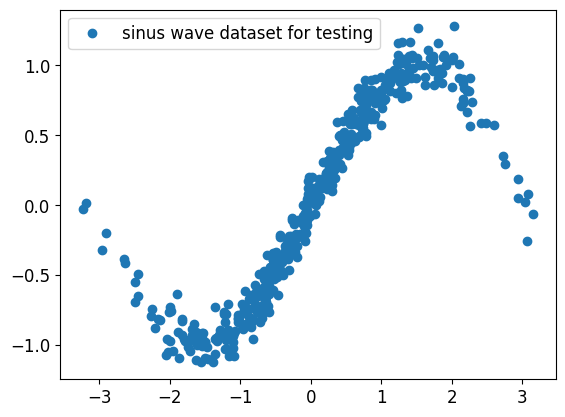

In [35]:
# Set parameters
lam = 0.0001
n = 500  # Number of points
sigma = 15  # Adjusted width parameter for variation
scale_factor = 1.2  # Scale factor for input variance
noise_factor = 0.1  # Adjusted noise level

# Generate sample data
np.random.seed(42)  # For reproducibility
noise = np.random.randn(n) * noise_factor
x = np.random.randn(n) * scale_factor
y = np.sin(x) + noise  # Using sine function with noise

#sigma, lambda_ = [0.0001, 5]
def rbfkernel(x, z, sigma):
    k = np.exp(-(abs(x - z)**2)/(2 * sigma**2))
    return k

def gram(x_list, z_list, sigma):
    n = len(x_list)
    k_mat = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            k_mat[i][j] = rbfkernel(x_list[i], z_list[j], sigma)
    return k_mat
sig = 5    
K = gram(pos_data, pos_data, sig)
K_2 = gram(x, x, sig)
plt.plot(x, y, 'o', label="sinus wave dataset for testing")
plt.legend()
plt.savefig("test_dataset_for_scalar_rkhs.png")
plt.show()


### Solve the minimization problem to obtain dual coefficients $a$

In [28]:
def dual_coeff(K, y, lambd):
    n = K.shape[0]
    K_reg = K + lambd * np.eye(n)
    alpha = np.linalg.solve(K_reg, y)
    return alpha
alfa = dual_coeff(K, vel_data, lam)
alfa_2 = dual_coeff(K_2, y, lam)

### Estimate the function based on $a$ and kernel matrix

In [29]:
def f(a, x):
    n = x.shape[0]
    f = np.zeros(n)
    for i in range(n):
        tot = 0
        for j in range(n):
            tot +=  a[j] * rbfkernel(x[i], x[j], sig)
        f[i] = tot
    return f
f_estimate = f(alfa, pos_data)
f_estimate_2 = f(alfa_2, x)

### plot results

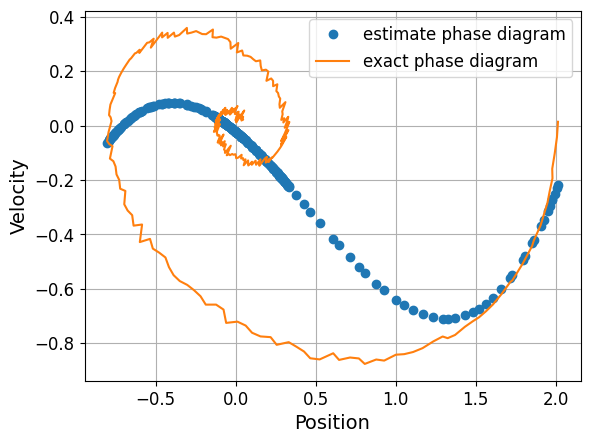

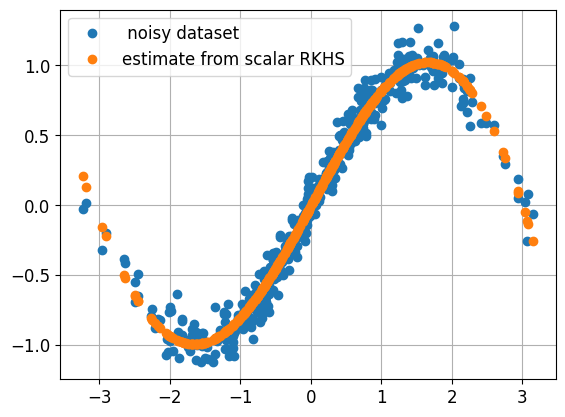

In [30]:
plt.plot(pos_data, f_estimate,'o', label = "estimate phase diagram")
plt.plot(pos_data, vel_data, label = "exact phase diagram")
plt.xlabel("Position")
plt.ylabel("Velocity")
plt.legend()
plt.grid()
plt.savefig("rkhs_pos_in_vel_ut.png")
plt.show()

plt.plot(x, y, 'o', label = " noisy dataset")
plt.plot(x, f_estimate_2, 'o', label = "estimate from scalar RKHS")
plt.legend()
plt.grid()
plt.savefig("test_for_Scalar_RKHS.png")
plt.show()
